In [33]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
import wandb
import matplotlib.pyplot as plt

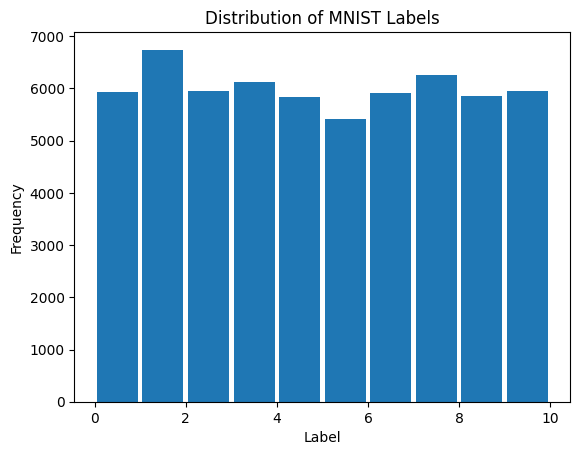

In [34]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data/', train=False, download=True, transform=transform)

labels = train_dataset.targets.numpy()

plt.hist(labels, bins=10, range=(0,10), rwidth=0.9)
plt.title('Distribution of MNIST Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [35]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [36]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

Class 0:


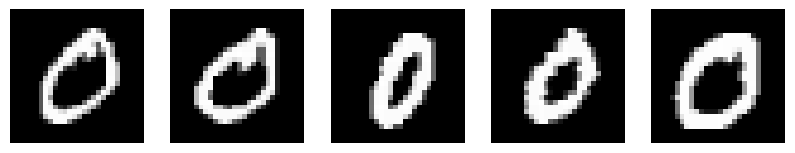

Class 1:


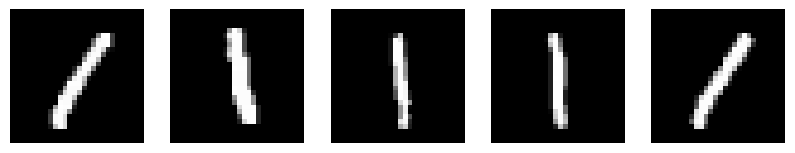

Class 2:


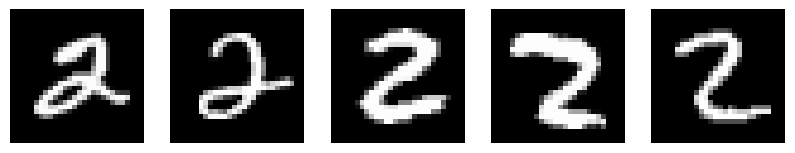

Class 3:


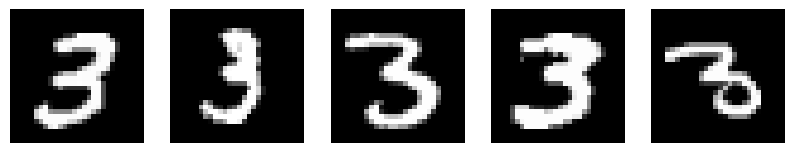

Class 4:


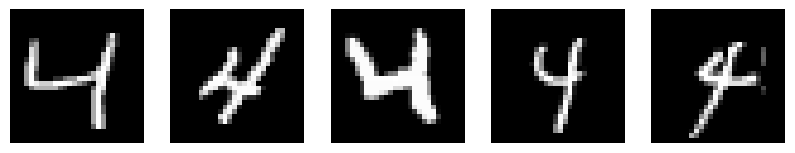

Class 5:


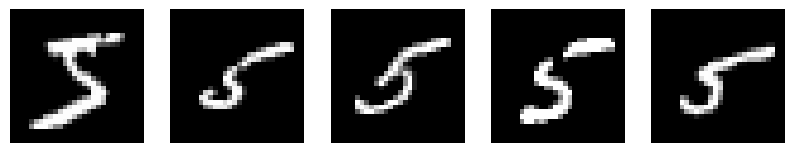

Class 6:


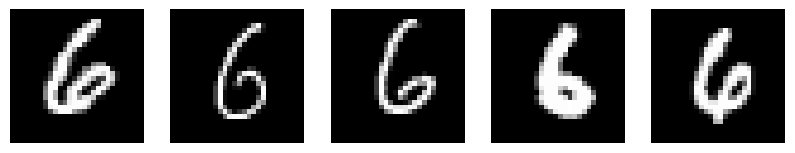

Class 7:


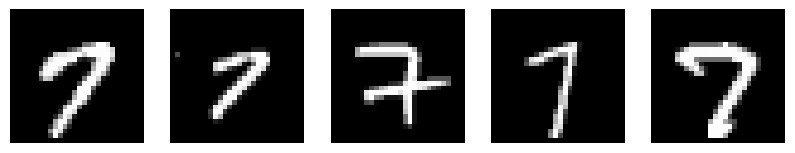

Class 8:


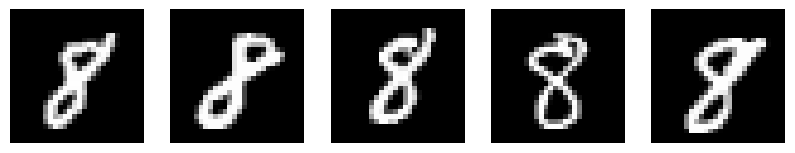

Class 9:


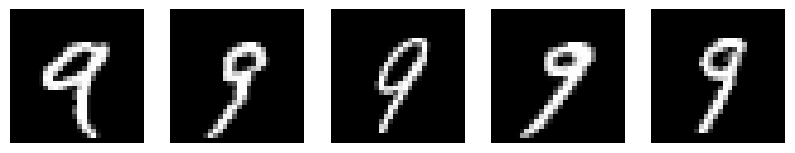

In [37]:
import numpy as np

# Function to display images
def display_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(10, 2))
    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

# Get 5 samples from each class
for i in range(10):
    indices = np.where(labels == i)[0][:5]
    images = [train_dataset[j][0].numpy().squeeze() for j in indices]
    print(f'Class {i}:')
    display_images(images)

### Class Imbalance

The histogram plotted in part1, denotes there is no imbalance between classes and all of them are roughly equal.

In [38]:
class CNN(nn.Module):
    def __init__(self, log_flag):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 10)
        self.dropout = nn.Dropout(0.5)
        self.log_flag = log_flag

    def set_hyperparameters(self, learning_rate, batch_size, kernel_size, stride, num_epochs, dropout_rate):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.num_epochs = num_epochs
        self.dropout_rate = dropout_rate

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.dropout(x)
        x = nn.functional.log_softmax(self.fc1(x), dim=1)
        return x

    def load_data(self):
        transform = transforms.ToTensor()
        train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
        num_samples = len(train_data)
        num_train = int(num_samples * 0.8)
        num_val = num_samples - num_train
        train_data, val_data = random_split(train_data, [num_train, num_val])
        test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
        return train_data, val_data, test_data

    def train(self, train_data, val_data):
        trainloader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
        valloader = torch.utils.data.DataLoader(val_data, batch_size=self.batch_size)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            correct_predictions_train = 0
            total_predictions_train = 0

            for images, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(images)
                _, predicted_labels = torch.max(outputs.data, 1)
                total_predictions_train += labels.size(0)
                correct_predictions_train += (predicted_labels == labels).sum().item()

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_accuracy = correct_predictions_train / total_predictions_train * 100

            with torch.no_grad():
                val_loss = sum(criterion(self(images), labels) for images, labels in valloader)
                correct_predictions_val = 0
                total_predictions_val = 0
                for images, labels in valloader:
                    outputs_val = self(images)
                    _, predicted_labels_val = torch.max(outputs_val.data, 1)
                    total_predictions_val += labels.size(0)
                    correct_predictions_val += (predicted_labels_val == labels).sum().item()

            val_accuracy = correct_predictions_val / total_predictions_val * 100
            
            if self.log_flag == 1:
                wandb.log({
                    "train_loss": running_loss / len(trainloader),
                    "val_loss": val_loss / len(valloader),
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy
                })

            print(f'Epoch {epoch + 1}: \nTraining Loss {running_loss/len(trainloader)}, \nTraining Accuracy {train_accuracy}%, \nValidation Loss {val_loss/len(valloader)}, \nValidation Accuracy {val_accuracy}%\n')

    def evaluate(self, test_data):
        testloader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size)

        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for images, labels in testloader:
                outputs = self(images)
                _, predicted_labels = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted_labels == labels).sum().item()

        print(f'Accuracy on test set: {correct_predictions / total_predictions * 100}%')

    def visualize_feature_maps(self):
        image, _ = test_data[0]
        x = image.unsqueeze(0)

        for i in range(2):
            if i == 0:
                x = nn.functional.relu(self.conv1(x))
            elif i == 1:
                x = nn.functional.relu(self.conv2(x))

        num_feature_maps = x.shape[1]
        rows = num_feature_maps // 3
        if num_feature_maps % 3:
            rows += 1
        fig, axs = plt.subplots(rows, 3, figsize=(6, rows*2))
        for i in range(num_feature_maps):
            row = i // 3
            col = i % 3
            axs[row, col].imshow(x[0, i].detach().numpy(), cmap='gray')
            axs[row, col].axis('off')
        plt.show()

In [40]:
learning_rate = 0.001
batch_size = 32
kernel_size = 3
stride = 1
num_epochs = 2
dropout_rate = 0.5

model = CNN(log_flag=0)
model.set_hyperparameters(learning_rate, batch_size, kernel_size, stride, num_epochs, dropout_rate)

train_data, val_data, test_data = model.load_data()
model.train(train_data, val_data)

Epoch 1: 
Training Loss 0.2173951444402337, 
Training Accuracy 93.3875%, 
Validation Loss 0.10455911606550217, 
Validation Accuracy 96.85000000000001%

Epoch 2: 
Training Loss 0.08251046607115617, 
Training Accuracy 97.41041666666666%, 
Validation Loss 0.07802839577198029, 
Validation Accuracy 97.51666666666667%



In [41]:
model.evaluate(test_data)

Accuracy on test set: 98.05%


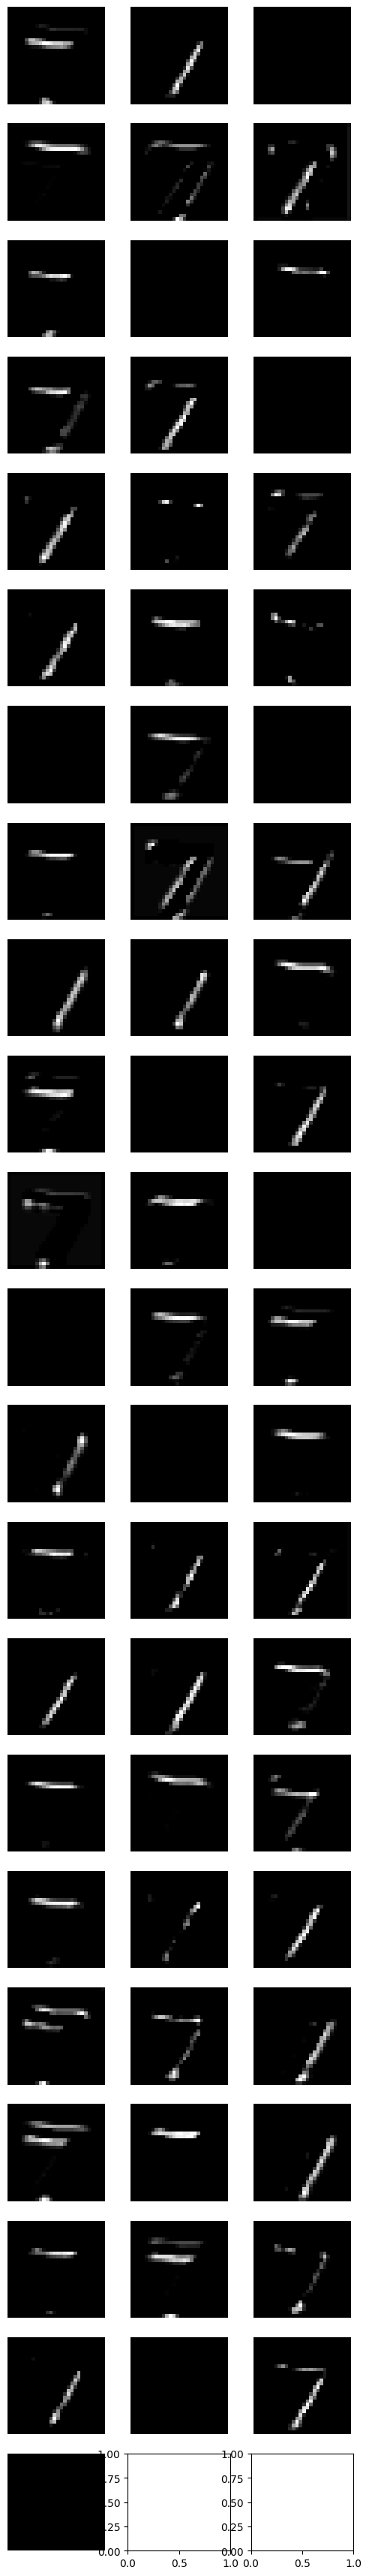

In [42]:
model.visualize_feature_maps()

In [43]:
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32]
kernel_sizes = [3, 5]
strides = [1, 2]
num_epochs = [2, 3]
dropout_rates = [0.3, 0.0]

In [ ]:
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         for kernel_size in kernel_sizes:
#             for stride in strides:
#                 for epochs in num_epochs:
#                     for dropout_rate in dropout_rates:
#                         wandb.init(project="CNN")
#                         hyperparameters = {
#                             "learning_rate": lr,
#                             "batch_size": batch_size,
#                             "kernel_size": kernel_size,
#                             "stride": stride,
#                             "num_epochs": epochs,
#                             "dropout_rate": dropout_rate
#                         }
                        
#                         model = CNN(log_flag=1)
#                         model.set_hyperparameters(
#                             lr, batch_size, kernel_size, stride, epochs, dropout_rate
#                         )

#                         train_data, val_data, test_data = model.load_data()
#                         model.train(train_data, val_data)  
                        
#                         wandb.finish()

## Noisy Data model

In [77]:
import scipy.io

# Load the .mat file
mat = scipy.io.loadmat('mnist-with-awgn.mat')

# Extract the training, validation and test sets
X_train = mat['train_x']
y_train = mat['train_y']

X_test = mat['test_x']
y_test = mat['test_y']

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [66]:
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
val_data = TensorDataset(X_val, y_val)

# Create data loaders
trainloader = DataLoader(train_data, batch_size=32)
testloader = DataLoader(test_data, batch_size=32)
valloader = DataLoader(val_data, batch_size=32)

In [68]:
model = CNN()
train_data,val_data,test_data=model.load_data()
model.train(train_data,val_data)
model.evaluate(test_data)

Epoch 1: 
Training Loss 0.2239629891080161, 
Training Accuracy 93.09791666666666%, 
Validation Loss 0.0944080799818039, 
Validation Accuracy 97.075%
Epoch 2: 
Training Loss 0.08509626804750102, 
Training Accuracy 97.3625%, 
Validation Loss 0.07452400773763657, 
Validation Accuracy 97.74166666666667%
Epoch 3: 
Training Loss 0.06994088372999492, 
Training Accuracy 97.80208333333333%, 
Validation Loss 0.06528324633836746, 
Validation Accuracy 97.90833333333333%
Epoch 4: 
Training Loss 0.05798940791321608, 
Training Accuracy 98.16458333333333%, 
Validation Loss 0.06083954498171806, 
Validation Accuracy 98.30833333333334%
Epoch 5: 
Training Loss 0.05168174085934879, 
Training Accuracy 98.375%, 
Validation Loss 0.05506500229239464, 
Validation Accuracy 98.36666666666667%
Epoch 6: 
Training Loss 0.04979126786183527, 
Training Accuracy 98.44791666666667%, 
Validation Loss 0.05257294699549675, 
Validation Accuracy 98.575%
Epoch 7: 
Training Loss 0.04169682650870527, 
Training Accuracy 98.679166

## MLP on Double MNIST

In [45]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import hamming_loss
import numpy as np
import pandas as pd


In [46]:
# Load the dataset
data_dir = 'double_mnist_seed_123_image_size_64_64'
train_data = datasets.ImageFolder(data_dir + '/train', transform=transforms.ToTensor())
val_data = datasets.ImageFolder(data_dir + '/val', transform=transforms.ToTensor())
test_data = datasets.ImageFolder(data_dir + '/test', transform=transforms.ToTensor())

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [47]:
# Print out the shape of an image tensor
image, label = next(iter(train_loader))
print(image.shape)

torch.Size([64, 3, 64, 64])


In [48]:
max_label = max(max(labels) for _, labels in train_loader)
print(max_label)


tensor(63)


In [51]:
class MLPDigit(nn.Module):
    def __init__(self, train_loader, val_loader):
        super(MLPDigit, self).__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader

        # Define the layers
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        return self.layers(x)

    def train_model(self, epochs):
        for epoch in range(epochs):
            self.train()
            train_loss = 0.0
            train_preds = []
            train_labels = []

            for images, labels in self.train_loader:
                labels = F.one_hot(labels, num_classes=64).float()

                outputs = self(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Calculate training loss
                train_loss += loss.item()

                # Store predictions and true labels for calculating Hamming Loss
                predicted = torch.sigmoid(outputs) > 0.5
                train_preds.append(predicted.cpu().numpy())
                train_labels.append(labels.cpu().numpy())

            train_loss /= len(self.train_loader)
            
            # Calculate Hamming Loss for training set
            hamming_error_train = hamming_loss(np.vstack(train_labels), np.vstack(train_preds))

            # Validation
            self.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for images, labels in self.val_loader:
                    labels = F.one_hot(labels, num_classes=64).float()
                    outputs = self(images)
                    loss = self.criterion(outputs, labels)

                    # Calculate validation loss
                    val_loss += loss.item()

                    # Store predictions and true labels for calculating Hamming Loss
                    predicted = torch.sigmoid(outputs) > 0.5
                    val_preds.append(predicted.cpu().numpy())
                    val_labels.append(labels.cpu().numpy())

            val_loss /= len(val_loader)
            
            # Calculate Hamming Loss for validation set
            hamming_error_val = hamming_loss(np.vstack(val_labels), np.vstack(val_preds))
            
            accuracy_train = 100 * (1 - hamming_error_train)
            accuracy_val = 100 * (1 - hamming_error_val)
            
            print(f'Epoch {epoch+1}\n'
                  f'Train Loss: {train_loss:.2f}\n'
                  f'Train Hamming Error: {hamming_error_train:.2f}\n'
                  f'Train Accuracy: {accuracy_train:.2f}\n'
                  f'Val Loss: {val_loss:.2f}\n'
                  f'Val Hamming Error: {hamming_error_val:.2f}\n'
                  f'Val Accuracy: {accuracy_val:.2f}\n')
            
            wandb.log({
                "Train Loss": train_loss,
                "train_accuracy": accuracy_train,
                "Val Loss": val_loss,
                "val_accuracy": accuracy_val,
            })
    
    def evaluate_model(self, test_loader):
        self.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        test_preds = []
        test_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                labels = F.one_hot(labels, num_classes=64).float()
                outputs = self(images)
                loss = self.criterion(outputs, labels)

                # Calculate loss
                test_loss += loss.item()

                # Store predictions and true labels for calculating Hamming Loss
                predicted = torch.sigmoid(outputs) > 0.5
                test_preds.append(predicted.cpu().numpy())
                test_labels.append(labels.cpu().numpy())

        test_loss /= len(test_loader)
            
        # Calculate Hamming Loss for validation set
        hamming_error_test = hamming_loss(np.vstack(test_labels), np.vstack(test_preds))
            
        accuracy = 100 * (1 - hamming_error_test)
            
        print(f'Test Hamming Error: {hamming_error_test:.2f}\n'
              f'Test Accuracy: {accuracy:.2f}\n')
        

In [52]:
model_MLP = MLPDigit(train_loader, val_loader)
model_MLP.train_model(10)


Epoch 1
Train Loss: 0.07
Train Hamming Error: 0.02
Train Accuracy: 98.39
Val Loss: 0.15
Val Hamming Error: 0.02
Val Accuracy: 98.32

Epoch 2
Train Loss: 0.03
Train Hamming Error: 0.01
Train Accuracy: 98.83
Val Loss: 0.21
Val Hamming Error: 0.02
Val Accuracy: 97.95

Epoch 3
Train Loss: 0.02
Train Hamming Error: 0.01
Train Accuracy: 99.28
Val Loss: 0.26
Val Hamming Error: 0.02
Val Accuracy: 97.75

Epoch 4
Train Loss: 0.01
Train Hamming Error: 0.01
Train Accuracy: 99.49
Val Loss: 0.30
Val Hamming Error: 0.02
Val Accuracy: 97.63

Epoch 5
Train Loss: 0.01
Train Hamming Error: 0.00
Train Accuracy: 99.62
Val Loss: 0.34
Val Hamming Error: 0.02
Val Accuracy: 97.59

Epoch 6
Train Loss: 0.01
Train Hamming Error: 0.00
Train Accuracy: 99.71
Val Loss: 0.39
Val Hamming Error: 0.03
Val Accuracy: 97.45

Epoch 7
Train Loss: 0.01
Train Hamming Error: 0.00
Train Accuracy: 99.77
Val Loss: 0.44
Val Hamming Error: 0.03
Val Accuracy: 97.46

Epoch 8
Train Loss: 0.01
Train Hamming Error: 0.00
Train Accuracy: 99

In [ ]:
model_MLP.evaluate_model(test_loader)

## CNN on Double Digit

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import hamming_loss
from torch.utils.data import DataLoader

In [54]:
class CNNModel(nn.Module):
    def __init__(self, train_loader, val_loader):
        super(CNNModel, self).__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, epochs):
        for epoch in range(epochs):
            self.train()
            train_loss = 0.0
            train_preds = []
            train_labels = []

            for images, labels in self.train_loader:
                labels = F.one_hot(labels, num_classes=64).float()

                outputs = self(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Calculate training loss
                train_loss += loss.item()

                # Store predictions and true labels for calculating Hamming Loss
                predicted = torch.sigmoid(outputs) > 0.5
                train_preds.append(predicted.cpu().numpy())
                train_labels.append(labels.cpu().numpy())

            train_loss /= len(self.train_loader)
            
            # Calculate Hamming Loss for training set
            hamming_error_train = hamming_loss(np.vstack(train_labels), np.vstack(train_preds))

            # Validation
            self.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for images, labels in self.val_loader:
                    labels = F.one_hot(labels, num_classes=64).float()
                    outputs = self(images)
                    loss = self.criterion(outputs, labels)

                    # Calculate validation loss
                    val_loss += loss.item()

                    # Store predictions and true labels for calculating Hamming Loss
                    predicted = torch.sigmoid(outputs) > 0.5
                    val_preds.append(predicted.cpu().numpy())
                    val_labels.append(labels.cpu().numpy())

            val_loss /= len(val_loader)
            
            # Calculate Hamming Loss for validation set
            hamming_error_val = hamming_loss(np.vstack(val_labels), np.vstack(val_preds))
            
            accuracy_train = 100 * (1 - hamming_error_train)
            accuracy_val = 100 * (1 - hamming_error_val)
            
            print(f'Epoch {epoch+1}\n'
                  f'Train Loss: {train_loss:.2f}\n'
                  f'Train Hamming Error: {hamming_error_train:.2f}\n'
                  f'Train Accuracy: {accuracy_train:.2f}\n'
                  f'Val Loss: {val_loss:.2f}\n'
                  f'Val Hamming Error: {hamming_error_val:.2f}\n'
                  f'Val Accuracy: {accuracy_val:.2f}\n')
    
    def evaluate_model(self, test_loader):
        self.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        test_preds = []
        test_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                labels = F.one_hot(labels, num_classes=64).float()
                outputs = self(images)
                loss = self.criterion(outputs, labels)

                # Calculate loss
                test_loss += loss.item()

                # Store predictions and true labels for calculating Hamming Loss
                predicted = torch.sigmoid(outputs) > 0.5
                test_preds.append(predicted.cpu().numpy())
                test_labels.append(labels.cpu().numpy())

        test_loss /= len(test_loader)
            
        # Calculate Hamming Loss for validation set
        hamming_error_test = hamming_loss(np.vstack(test_labels), np.vstack(test_preds))
            
        accuracy = 100 * (1 - hamming_error_test)
            
        print(f'Test Hamming Error: {hamming_error_test:.2f}\n'
              f'Test Accuracy: {accuracy:.2f}\n')
        

In [55]:
model = CNNModel(train_loader, val_loader)
model.train_model(10)

Epoch 1
Train Loss: 0.05
Train Hamming Error: 0.01
Train Accuracy: 98.59
Val Loss: 0.23
Val Hamming Error: 0.02
Val Accuracy: 97.72

Epoch 2
Train Loss: 0.01
Train Hamming Error: 0.01
Train Accuracy: 99.49
Val Loss: 0.31
Val Hamming Error: 0.02
Val Accuracy: 97.63

Epoch 3
Train Loss: 0.01
Train Hamming Error: 0.00
Train Accuracy: 99.73
Val Loss: 0.36
Val Hamming Error: 0.02
Val Accuracy: 97.69

Epoch 4
Train Loss: 0.01
Train Hamming Error: 0.00
Train Accuracy: 99.82
Val Loss: 0.44
Val Hamming Error: 0.02
Val Accuracy: 97.65

Epoch 5
Train Loss: 0.00
Train Hamming Error: 0.00
Train Accuracy: 99.88
Val Loss: 0.51
Val Hamming Error: 0.02
Val Accuracy: 97.66

Epoch 6
Train Loss: 0.00
Train Hamming Error: 0.00
Train Accuracy: 99.92
Val Loss: 0.58
Val Hamming Error: 0.03
Val Accuracy: 97.43

Epoch 7
Train Loss: 0.00
Train Hamming Error: 0.00
Train Accuracy: 99.93
Val Loss: 0.66
Val Hamming Error: 0.03
Val Accuracy: 97.40

Epoch 8
Train Loss: 0.00
Train Hamming Error: 0.00
Train Accuracy: 99

In [56]:
model.evaluate_model(test_loader)

Test Hamming Error: 0.03
Test Accuracy: 97.47



### Evaluate on Single Digit

In [81]:
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

#### CNN evaluation

In [87]:
# model.evaluate_model(test_loader)

#### MLP evaluation

In [86]:
# model_MLP.evaluate_model(test_loader)

## Permuted MNIST

In [61]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [62]:
# To load the dataset, you can use np.load
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
x_test = data["test_images"]
y_test = data["test_labels"]

In [63]:
x_train, x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.2, random_state=42)

In [64]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (48000, 28, 28)
y_train shape: (48000,)
x_val shape: (12000, 28, 28)
y_val shape: (12000,)


## MLP on Permuted

In [65]:
class MLPPermuted(nn.Module):
    def __init__(self, train_loader, val_loader):
        super(MLPPermuted, self).__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # Define the layers
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),  # Input size is 28*28 as per your data
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # There are 10 classes (digits 0-9) in MNIST
        )

        self.criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        return self.layers(x)

    def train_model(self, epochs):
        for epoch in range(epochs):
            self.train()
            train_loss = 0.0
            correct_preds_train = 0
            total_preds_train = 0

            for images, labels in self.train_loader:
                outputs = self(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Calculate training loss
                train_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_preds_train += labels.size(0)
                correct_preds_train += (predicted == labels).sum().item()

            train_loss /= len(self.train_loader)
            accuracy_train = 100 * correct_preds_train / total_preds_train

            # Validation
            self.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            correct_preds_val = 0
            total_preds_val = 0

            with torch.no_grad():
                for images, labels in self.val_loader:
                    outputs = self(images)
                    loss = self.criterion(outputs, labels)

                    # Calculate validation loss
                    val_loss += loss.item()

                    # Calculate validation accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total_preds_val += labels.size(0)
                    correct_preds_val += (predicted == labels).sum().item()

            val_loss /= len(self.val_loader)
            accuracy_val = 100 * correct_preds_val / total_preds_val

            print(f'Epoch {epoch+1}\n'
                  f'Train Loss: {train_loss:.2f}\n'
                  f'Train Accuracy: {accuracy_train:.2f}\n'
                  f'Val Loss: {val_loss:.2f}\n'
                  f'Val Accuracy: {accuracy_val:.2f}\n')

    def evaluate_model(self, test_loader):
        self.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        correct_preds_test = 0
        total_preds_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self(images)
                loss = self.criterion(outputs, labels)

                # Calculate test loss
                test_loss += loss.item()

                # Calculate test accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_preds_test += labels.size(0)
                correct_preds_test += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        accuracy_test = 100 * correct_preds_test / total_preds_test

        print(f'Test Loss: {test_loss:.2f}\n'
              f'Test Accuracy: {accuracy_test:.2f}\n')


In [66]:
x_train_tensor = torch.tensor(x_train).float()
y_train_tensor = torch.tensor(y_train).long()
x_val_tensor = torch.tensor(x_val).float()
y_val_tensor = torch.tensor(y_val).long()
x_test_tensor = torch.tensor(x_test).float()
y_test_tensor = torch.tensor(y_test).long()

In [67]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [68]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [69]:
mlp_permuted = MLPPermuted(train_loader, val_loader)
mlp_permuted.train_model(10)

Epoch 1
Train Loss: 0.41
Train Accuracy: 91.95
Val Loss: 0.16
Val Accuracy: 95.22

Epoch 2
Train Loss: 0.13
Train Accuracy: 95.94
Val Loss: 0.12
Val Accuracy: 96.49

Epoch 3
Train Loss: 0.11
Train Accuracy: 96.74
Val Loss: 0.11
Val Accuracy: 96.70

Epoch 4
Train Loss: 0.10
Train Accuracy: 97.13
Val Loss: 0.13
Val Accuracy: 96.49

Epoch 5
Train Loss: 0.09
Train Accuracy: 97.32
Val Loss: 0.13
Val Accuracy: 96.60

Epoch 6
Train Loss: 0.09
Train Accuracy: 97.50
Val Loss: 0.14
Val Accuracy: 96.55

Epoch 7
Train Loss: 0.08
Train Accuracy: 97.58
Val Loss: 0.15
Val Accuracy: 96.73

Epoch 8
Train Loss: 0.08
Train Accuracy: 97.71
Val Loss: 0.18
Val Accuracy: 95.95

Epoch 9
Train Loss: 0.06
Train Accuracy: 98.24
Val Loss: 0.20
Val Accuracy: 96.26

Epoch 10
Train Loss: 0.07
Train Accuracy: 98.07
Val Loss: 0.14
Val Accuracy: 96.73



In [70]:
mlp_permuted.evaluate_model(test_loader)

Test Loss: 0.13
Test Accuracy: 96.91



## CNN on Permuted

In [77]:
class CNNPermuted(nn.Module):
    def __init__(self, train_loader, val_loader):
        super(CNNPermuted, self).__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

    def train_model(self, epochs):
        for epoch in range(epochs):
            self.train()
            train_loss = 0.0
            correct_train_preds = 0
            total_train_preds = 0
            for images, labels in self.train_loader:
                outputs = self(images.unsqueeze(1))
                loss = self.criterion(outputs, labels) 
                _, predicted = torch.max(outputs.data, 1)
                total_train_preds += labels.size(0)
                correct_train_preds += (predicted == labels).sum().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            train_loss /= len(self.train_loader)
            accuracy_train = 100 * correct_train_preds / total_train_preds
            
            self.eval()
            val_loss = 0.0
            correct_val_preds = 0
            total_val_preds = 0
            for images, labels in self.val_loader:
                outputs = self(images.unsqueeze(1))
                loss = self.criterion(outputs, labels) 
                _, predicted = torch.max(outputs.data, 1)
                total_val_preds += labels.size(0)
                correct_val_preds += (predicted == labels).sum().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                val_loss += loss.item()

            val_loss /= len(self.val_loader)
            accuracy_val = 100 * correct_val_preds / total_val_preds

            print(f'Epoch {epoch+1}\n'
                  f'Train Loss: {train_loss:.2f}\n'
                  f'Train Accuracy: {accuracy_train:.2f}\n'
                  f'Val Loss: {val_loss:.2f}\n'
                  f'Val Accuracy: {accuracy_val:.2f}\n')
            
    def eval_model(self, test_loader):
        self.eval()
        test_loss = 0.0
        correct_test_preds = 0
        total_test_preds = 0
        for images, labels in test_loader:
            outputs = self(images.unsqueeze(1))
            loss = self.criterion(outputs, labels) 
            _, predicted = torch.max(outputs.data, 1)
            total_test_preds += labels.size(0)
            correct_test_preds += (predicted == labels).sum().item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            test_loss += loss.item()

        test_loss /= len(test_loader)
        accuracy_test = 100 * correct_test_preds / total_test_preds

        print(f'Test Loss: {test_loss:.2f}\n'
              f'Test Accuracy: {accuracy_test:.2f}\n')


In [79]:
cnn_permuted = CNNPermuted(train_loader, val_loader)

In [75]:
cnn_permuted.train_model(5)

Epoch 1
Train Loss: 0.09
Train Accuracy: 97.03
Val Loss: 0.11
Val Accuracy: 96.60

Epoch 2
Train Loss: 0.08
Train Accuracy: 97.50
Val Loss: 0.07
Val Accuracy: 97.60

Epoch 3
Train Loss: 0.07
Train Accuracy: 97.57
Val Loss: 0.08
Val Accuracy: 97.53

Epoch 4
Train Loss: 0.06
Train Accuracy: 97.92
Val Loss: 0.06
Val Accuracy: 98.17

Epoch 5
Train Loss: 0.06
Train Accuracy: 98.15
Val Loss: 0.06
Val Accuracy: 98.17



In [90]:
cnn_permuted.eval_model(test_loader)

Test Loss: 1.78
Test Accuracy: 98.22
